# GGA 方法 U 矩阵与 B2PLYP 型泛函核坐标梯度

我们进一步讨论 GGA 方法的 U 矩阵求取方式。在求取 U 矩阵的过程中，我们利用到 GGA 方法下的 CP-HF 方程，进而可以用来求取含有 GGA 的 B2PLYP 型泛函的弛豫密度矩阵 $D_{pq}^\mathrm{MP2}$，进而得到 B2PLYP 型泛函核坐标梯度。

在 pyxdh 中，B2PLYP 型泛函与 MP2 方法使用相同的流程进行处理；这两者相当相似。这一节的大多数公式和做法都可以参考 MP2 梯度部分；但在一些公式细节上，需要留意细微的差别。

这一节中提到的 U 矩阵求取仅仅包括非占-占据部分 $U_{ai}^{A_t}$。

## 准备工作

计算 B2PLYP 型泛函的梯度，我们用与 MP2 方法一样的 `GradMP2` 类。由于涉及到大批格点的计算，我们这里暂时假定供给 np.einsum 的内存大小是足够大的。

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, dft, lib, hessian
from pyscf.scf import cphf
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from pyxdh.Utilities import NucCoordDerivGenerator, DipoleDerivGenerator, NumericDiff, GridHelper, KernelHelper
from pyxdh.DerivOnce import GradMP2, GradSCF

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 1000 / 8])
np.einsum_path = partial(np.einsum_path, optimize=["greedy", 1024 ** 3 * 1000 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

In [3]:
def mol_to_grids(mol, atom_grid=(75, 302)):
    grids = dft.Grids(mol)
    grids.atom_grid = atom_grid
    grids.becke_scheme = dft.gen_grid.stratmann
    grids.prune = None
    grids.build()
    return grids
grids = mol_to_grids(mol)

但需要注意到，既然我们计算的是 B2PLYP，那么其泛函也需要更改为 B2PLYP 的自洽场过程中使用的泛函：

In [4]:
def mol_to_scf(mol):
    scf_eng = dft.RKS(mol)
    scf_eng.grids = mol_to_grids(mol)
    scf_eng.xc = "0.53*HF + 0.47*B88, 0.73*LYP"
    scf_eng.conv_tol = 1e-10
    return scf_eng.run()

与 MP2 方法不同的是，我们需要额外定义 PT2 相关能系数 `cc` $c_\mathrm{c}$：

In [5]:
gradh = GradMP2({"scf_eng": mol_to_scf(mol), "cc": 0.27})
cc = gradh.cc

In [6]:
nmo, nao, natm, nocc, nvir, cx = gradh.nao, gradh.nao, gradh.natm, gradh.nocc, gradh.nvir, gradh.cx
mol_slice = gradh.mol_slice
so, sv, sa = gradh.so, gradh.sv, gradh.sa
C, Co, Cv, e, eo, ev, D = gradh.C, gradh.Co, gradh.Cv, gradh.e, gradh.eo, gradh.ev, gradh.D
H_0_ao, S_0_ao, eri0_ao, F_0_ao = gradh.H_0_ao, gradh.S_0_ao, gradh.eri0_ao, gradh.F_0_ao
H_0_mo, S_0_mo, eri0_mo, F_0_mo = gradh.H_0_mo, gradh.S_0_mo, gradh.eri0_mo, gradh.F_0_mo

In [7]:
def to_natm_3(mat: np.ndarray):
    shape = list(mat.shape)
    shape = [int(shape[0] / 3), 3] + shape[1:]
    return mat.reshape(shape)

In [8]:
H_1_ao, S_1_ao, eri1_ao = to_natm_3(gradh.H_1_ao), to_natm_3(gradh.S_1_ao), to_natm_3(gradh.eri1_ao)
H_1_mo, S_1_mo, eri1_mo = to_natm_3(gradh.H_1_mo), to_natm_3(gradh.S_1_mo), to_natm_3(gradh.eri1_mo)

In [9]:
grdh = GridHelper(mol, grids, D)
kerh = KernelHelper(grdh, "0.53*HF + 0.47*B88, 0.73*LYP")

为了简化后面程序代码，我们将一部分与格点相关的 (基于 $D_{\mu \nu}$ 自洽场密度给出的) 变量定义如下：

In [10]:
ao_0, ao_1, ao_2 = grdh.ao_0, grdh.ao_1, grdh.ao_2
rho_1, rho_2 = grdh.rho_1, grdh.rho_2
A_rho_1, A_rho_2 = grdh.A_rho_1, grdh.A_rho_2
fr, fg, frr, frg, fgg = kerh.fr, kerh.fg, kerh.frr, kerh.frg, kerh.fgg

In [11]:
def grad_generator(mol):
    scf_eng = mol_to_scf(mol)
    config = {"scf_eng": mol_to_scf(mol), "cc": 0.27}
    return GradMP2(config)
gradn = NucCoordDerivGenerator(mol, grad_generator)

## GGA 方法 U 矩阵的求取

### Fock Skeleton 导数

求取 U 矩阵 (非占-占据部分) 的推导前提是 Fock 矩阵 $F_{ai} = 0$。我们首先回顾原子轨道下，GGA 的 Fock 矩阵定义：

$$
F_{\mu \nu} = h_{\mu \nu} + (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{c_\mathrm{x}}{2} (\mu \kappa | \nu \lambda) D_{\kappa \lambda} + v_{\mu \nu}^\mathrm{xc}
$$

前三项我们已经在 RHF 的 U 矩阵计算时知道了求取方法；现在我们要考虑第四项 $v_{\mu \nu}^\mathrm{xc}$ 导数的计算。我们再回顾 $v_{\mu \nu}^{\mathrm{xc}}$ 的定义：

$$
v_{\mu \nu}^\mathrm{xc} = f_\rho \phi_\mu \phi_\nu + 2 f_\gamma \rho_r (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu})
$$

我们对 Skeleton 导数的定义是不包含 $C_{\mu p}$ 的导数；剩下的部分则归为 U 矩阵导数。我们将 $v_{\mu \nu}^{\mathrm{xc}}$ 的 Skeleton 导数写为 $v_{\mu \nu}^{\mathrm{xc}, A_t}$。

我们先依据链式法则，考察 $f_\rho$ 的全导数：

$$
\frac{\partial f_\rho}{\partial A_t} = f_{\rho \rho} \frac{\partial \rho}{\partial A_t} + 2 f_{\rho \gamma} \rho_r \frac{\partial \rho_r}{\partial A_t}
$$

我们已经对 $\partial_{A_t} \rho$ 与 $\partial_{A_t} \rho_r$ 作过讨论：

$$
\begin{align}
\frac{\partial \rho}{\partial A_t}
&= - \phi_{t \mu_A} \phi_\nu D_{\mu \nu} - \phi_\mu \phi_{t \nu_A} D_{\mu \nu} + 4 \phi_\mu \phi_\nu U_{mi}^{A_t} C_{\mu m} C_{\nu i} \\
&= \rho^{A_t} + 4 \phi_\mu \phi_\nu U_{mi}^{A_t} C_{\mu m} C_{\nu i} \\
\frac{\partial \rho_r}{\partial A_t}
&= - 2 \phi_{tr \mu_A} \phi_\nu D_{\mu \nu} - 2 \phi_{r \mu} \phi_{t \nu_A} D_{\mu \nu} + 4 (\phi_{r \mu} \phi_\nu + \phi_\mu \phi_{r \nu}) U_{mi}^{A_t} C_{\mu m} C_{\nu i} \\
&= \rho_r^{A_t} + 4 (\phi_{r \mu} \phi_\nu + \phi_\mu \phi_{r \nu}) U_{mi}^{A_t} C_{\mu m} C_{\nu i}
\end{align}
$$

对于 $f_\gamma$ 的全导数也是相同的：

$$
\frac{\partial f_\gamma}{\partial A_t} = f_{\rho \gamma} \frac{\partial \rho}{\partial A_t} + 2 f_{\gamma \gamma} \rho_r \frac{\partial \rho_r}{\partial A_t}
$$

上述出现了 U 矩阵的部分看作是 U 导数，否则为 Skeleton 导数。那么，$v_{\mu \nu}^\mathrm{xc}$ 的所有贡献项就容易地用链式法则表示如下：

$$
\begin{align}
\partial_{A_t} v_{\mu \nu}^\mathrm{xc} \xleftarrow{\text{Skeleton derivative}} v_{\mu \nu}^{\mathrm{xc}, A_t}
&= (f_{\rho \rho} \rho^{A_t} + 2 f_{\rho \gamma} \rho_w \rho_w^{A_t}) \phi_\mu \phi_\nu + 2 (f_{\rho \gamma} \rho^{A_t} + 2 f_{\gamma \gamma} \rho_w \rho_w^{A_t}) \rho_r \rho_r^{A_t} (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu}) \\
&\quad + f_\rho \phi_\mu^{A_t} \phi_\nu + f_\rho \phi_\mu \phi_\nu^{A_t} \\
&\quad + 2 f_\gamma \rho_r^{A_t} (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu})
+ 2 f_\gamma \rho_r (\phi_{r \mu}^{A_t} \phi_{\nu} + \phi_{\mu}^{A_t} \phi_{r \nu} + \phi_{r \mu} \phi_{\nu}^{A_t} + \phi_{\mu} \phi_{r \nu}^{A_t})
\end{align}
$$

上述出现了 U 矩阵的部分看作是 U 导数，否则为 Skeleton 导数。那么，$v_{\mu \nu}^\mathrm{xc}$ 的所有贡献项就容易地用链式法则表示如下：

$$
\begin{align}
\partial_{A_t} v_{\mu \nu}^\mathrm{xc} \xleftarrow{\text{Skeleton derivative}} v_{\mu \nu}^{\mathrm{xc}, A_t}
&= (f_{\rho \rho} \rho^{A_t} + 2 f_{\rho \gamma} \rho_w \rho_w^{A_t}) \phi_\mu \phi_\nu \\
&\quad + 2 (f_{\rho \gamma} \rho^{A_t} + 2 f_{\gamma \gamma} \rho_w \rho_w^{A_t}) \rho_r (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu}) \\
&\quad + f_\rho \phi_\mu^{A_t} \phi_\nu + f_\rho \phi_\mu \phi_\nu^{A_t} \\
&\quad + 2 f_\gamma \rho_r^{A_t} (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu})
+ 2 f_\gamma \rho_r (\phi_{r \mu}^{A_t} \phi_{\nu} + \phi_{\mu}^{A_t} \phi_{r \nu} + \phi_{r \mu} \phi_{\nu}^{A_t} + \phi_{\mu} \phi_{r \nu}^{A_t}) \\
&= \frac{1}{2} f_{\rho \rho} \rho^{A_t} \phi_\mu \phi_\nu + f_{\rho \gamma} \rho_w \rho_w^{A_t} \phi_\mu \phi_\nu \\
&\quad + 2 f_{\rho \gamma} \rho^{A_t} \rho_r \phi_{r \mu} \phi_{\nu} + 4 f_{\gamma \gamma} \rho_w \rho_w^{A_t} \rho_r \phi_{r \mu} \phi_{\nu} \\
&\quad + f_\rho \phi_\mu^{A_t} \phi_\nu \\
&\quad + 2 f_\gamma \rho_r^{A_t} \phi_{r \mu} \phi_{\nu} + 2 f_\gamma \rho_r \phi_{r \mu}^{A_t} \phi_{\nu} + 2 f_\gamma \rho_r \phi_{\mu}^{A_t} \phi_{r \nu} \\
&\quad + \mathrm{swap} (\mu, \nu)
\end{align}
$$

利用 $\partial_{A_t} \phi_\mu = - \phi_{t \mu_A}$ 等结论，我们会将上式写为

$$
\begin{align}
\partial_{A_t} v_{\mu \nu}^\mathrm{xc} \xleftarrow{\text{Skeleton derivative}} v_{\mu \nu}^{\mathrm{xc}, A_t}
&= \frac{1}{2} f_{\rho \rho} \rho^{A_t} \phi_\mu \phi_\nu + f_{\rho \gamma} \rho_w \rho_w^{A_t} \phi_\mu \phi_\nu \\
&\quad + 2 f_{\rho \gamma} \rho^{A_t} \rho_r \phi_{r \mu} \phi_{\nu} + 4 f_{\gamma \gamma} \rho_w \rho_w^{A_t} \rho_r \phi_{r \mu} \phi_{\nu} \\
&\quad + 2 f_\gamma \rho_r^{A_t} \phi_{r \mu} \phi_{\nu} \\
&\quad - f_\rho \phi_{t \mu_A} \phi_\nu - 2 f_\gamma \rho_r \phi_{tr \mu_A} \phi_{\nu} - 2 f_\gamma \rho_r \phi_{t \mu_A} \phi_{r \nu} \\
&\quad + \mathrm{swap} (\mu, \nu)
\end{align}
$$

我们定义 `F_1_ao_GGA` $v_{\mu \nu}^{\mathrm{xc}, A_t}$ 为 (维度为 $(A, t, \mu, \nu)$)

In [12]:
F_1_ao_GGA = (
    + 0.5 * np.einsum("g, Atg, gu, gv -> Atuv", frr, A_rho_1, ao_0, ao_0)
    + np.einsum("g, wg, Atwg, gu, gv -> Atuv", frg, rho_1, A_rho_2, ao_0, ao_0)
    + 2 * np.einsum("g, Atg, rg, rgu, gv -> Atuv", frg, A_rho_1, rho_1, ao_1, ao_0)
    + 4 * np.einsum("g, wg, Atwg, rg, rgu, gv -> Atuv", fgg, rho_1, A_rho_2, rho_1, ao_1, ao_0)
    + 2 * np.einsum("g, Atrg, rgu, gv -> Atuv", fg, A_rho_2, ao_1, ao_0)
)
for A in range(natm):
    sA = mol_slice(A)
    F_1_ao_GGA[A, :, sA, :] -= np.einsum("g, tgu, gv -> tuv", fr, ao_1[:, :, sA], ao_0)
    F_1_ao_GGA[A, :, sA, :] -= 2 * np.einsum("g, rg, trgu, gv -> tuv", fg, rho_1, ao_2[:, :, :, sA], ao_0)
    F_1_ao_GGA[A, :, sA, :] -= 2 * np.einsum("g, rg, tgu, rgv -> tuv", fg, rho_1, ao_1[:, :, sA], ao_1)
F_1_ao_GGA += F_1_ao_GGA.swapaxes(-1, -2)  # swap (u, v)
F_1_ao_GGA.shape

(4, 3, 22, 22)

我们再考虑 Fock 矩阵的 Skeleton 导数 `F_1_ao`：

$$
F_{\mu \nu}^{A_t} = h_{\mu \nu}^{A_t} + (\mu \nu | \kappa \lambda)^{A_t} D_{\kappa \lambda} - \frac{c_\mathrm{x}}{2} (\mu \kappa | \nu \lambda)^{A_t} D_{\kappa \lambda} + v_{\mu \nu}^{\mathrm{xc}, A_t}
$$

In [13]:
F_1_ao = (
    + H_1_ao
    + np.einsum("Atuvkl, kl -> Atuv", eri1_ao, D)
    - 0.5 * cx * np.einsum("Atukvl, kl -> Atuv", eri1_ao, D)
    + F_1_ao_GGA
)
F_1_ao.shape

(4, 3, 22, 22)

pyxdh 中的 `F_1_ao` 也可以用来验证上述的生成结果：

In [14]:
np.allclose(F_1_ao, to_natm_3(gradh.F_1_ao))

True

在 PySCF 中，也可以用 `make_h1` 来验证上述结果：

In [15]:
np.allclose(F_1_ao, hessian.rks.Hessian(gradh.scf_eng).make_h1(C, gradh.mo_occ))

True

那么分子轨道下的 $F_{pq}^{A_t}$ 可以表示为：

$$
F_{pq}^{A_t} = C_{\mu p} F_{\mu \nu}^{A_t} C_{\nu q}
$$

In [16]:
F_1_mo = np.einsum("up, Atuv, vq -> Atpq", C, F_1_ao, C)

### A 张量

我们已经对 $\partial_{A_t} \rho$ 与 $\partial_{A_t} \rho_r$ 作过讨论：

$$
\begin{align}
\frac{\partial \rho}{\partial A_t}
&= \rho^{A_t} + 4 \phi_\mu \phi_\nu U_{mi}^{A_t} C_{\mu m} C_{\nu i} \\
\frac{\partial \rho_r}{\partial A_t}
&= \rho_r^{A_t} + 4 (\phi_{r \mu} \phi_\nu + \phi_\mu \phi_{r \nu}) U_{mi}^{A_t} C_{\mu m} C_{\nu i}
\end{align}
$$

从 RHF 推导 A 张量的经验，我们知道，A 张量的定义应是 Fock 矩阵的 U 导数所产生的贡献：

$$
\frac{\partial F_{\mu \nu}}{\partial A_t} \xleftarrow{\text{U derivative}} A_{\mu \nu, \kappa \lambda} C_{\kappa m} C_{\lambda i} U_{mi}^{A_t}
$$

我们仍然根据定义

$$
v_{\mu \nu}^\mathrm{xc} = f_\rho \phi_\mu \phi_\nu + 2 f_\gamma \rho_r (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu})
$$

可以推知其 U 矩阵的贡献是

$$
\begin{align}
\partial_{A_t} v_{\mu \nu}^\mathrm{xc} \xleftarrow{\text{U derivative}}
&\quad \big[ 4 (f_{\rho \rho} \phi_\kappa \phi_\lambda + 2 f_{\rho \gamma} \rho_r \phi_{r \kappa} \phi_\lambda + 2 f_{\rho \gamma} \rho_r \phi_\kappa \phi_{r \lambda}) \phi_\mu \phi_\nu \\
&\quad + 8 (f_{\rho \gamma} \phi_\kappa \phi_\lambda + 2 f_{\gamma \gamma} \rho_w \phi_{w \kappa} \phi_\lambda + 2 f_{\gamma \gamma} \rho_r \phi_\kappa \phi_{r \lambda}) \rho_r (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu}) \\
&\quad + 8 f_\gamma (\phi_{r \kappa} \phi_\lambda + \phi_\kappa \phi_{r \lambda}) (\phi_{r \mu} \phi_{\nu} + \phi_{\mu} \phi_{r \nu}) \big] U_{mi}^{A_t} C_{\mu m} C_{\nu i}
\end{align}
$$

上式中，方括号所包含的部分就是 GGA 对 A 张量 $A_{\mu \nu, \kappa \lambda}$ 的贡献；但这个表达式实在是相当长，我们可以依靠对称性作一些简化：

$$
\begin{align}
A_{\mu \nu, \kappa \lambda} \xleftarrow{\text{GGA contrib}} A_{\mu \nu, \kappa \lambda}^\text{GGA}
&= f_{\rho \rho} \phi_\kappa \phi_\lambda \phi_\mu \phi_\nu + 4 f_{\rho \gamma} \rho_r \phi_{r \kappa} \phi_\lambda \phi_\mu \phi_\nu \\
& + 4 f_{\rho \gamma} \phi_\kappa \phi_\lambda \rho_r \phi_{r \mu} \phi_{\nu} + 16 f_{\gamma \gamma} \rho_w \phi_{w \kappa} \phi_\lambda \rho_r \phi_{r \mu} \phi_{\nu} \\
& + 8 f_\gamma \phi_{r \kappa} \phi_\lambda \phi_{r \mu} \phi_{\nu} \\
& + \mathrm{swap} (\mu, \nu) + \mathrm{swap} (\kappa, \lambda)
\end{align}
$$

In [17]:
A_0_ao_GGA = (
    + np.einsum("g, gk, gl, gu, gv -> uvkl", frr, ao_0, ao_0, ao_0, ao_0)
    + 4 * np.einsum("g, rg, rgk, gl, gu, gv -> uvkl", frg, rho_1, ao_1, ao_0, ao_0, ao_0)
    + 4 * np.einsum("g, gk, gl, rg, rgu, gv -> uvkl", frg, ao_0, ao_0, rho_1, ao_1, ao_0)
    + 16 * np.einsum("g, wg, wgk, gl, rg, rgu, gv -> uvkl", fgg, rho_1, ao_1, ao_0, rho_1, ao_1, ao_0)
    + 8 * np.einsum("g, rgk, gl, rgu, gv -> uvkl", fg, ao_1, ao_0, ao_1, ao_0)
)
A_0_ao_GGA += A_0_ao_GGA.swapaxes(-1, -2)
A_0_ao_GGA += A_0_ao_GGA.swapaxes(-3, -4)
A_0_ao_GGA.shape

(22, 22, 22, 22)

随后我们就可以给出 GGA 下的 A 张量：

$$
A_{\mu \nu, \kappa \lambda} = 4 (\mu \nu | \kappa \lambda) - c_\mathrm{x} (\mu \kappa | \nu \lambda) - c_\mathrm{x} (\mu \lambda | \nu \kappa) + A_{\mu \nu, \kappa \lambda}^\mathrm{GGA}
$$

In [18]:
A_0_ao = 4 * eri0_ao - cx * eri0_ao.swapaxes(-2, -3) - cx * eri0_ao.swapaxes(-1, -3) + A_0_ao_GGA

我们可以拿现成的程序来验证上述 A 张量是否生成正确。pyxdh 中，它仍然可以用 `Ax0_Core` 与张量作乘积得到：(下式对除了 $p, q$ 之外的角标求和)

$$
A_{pq, mi} X_{mi} = C_{\mu p} C_{\nu q} A_{\mu \nu, \kappa \lambda} C_{\kappa m} X_{mi} C_{\lambda i}
$$

In [19]:
X = np.random.randn(nmo, nocc)

In [20]:
np.allclose(
    np.einsum("up, vq, uvkl, km, mi, li -> pq", C, C, A_0_ao, C, X, Co),
    gradh.Ax0_Core(sa, sa, sa, so)(X)
)

True

<div class="alert alert-info">

**演示 A 张量 GGA 贡献部分的缩并效率**

你可能会意识到上述生成 `A_0_ao_GGA` 的耗时相当长，但 `Ax0_Core` 的耗时却很短。请尝试用 `np.einsum_path` 分析时间复杂度，并指出一种策略，使得计算 $A_{pq, mi} X_{mi}$ 的耗时与 `Ax0_Core` 相对接近。

</div>

### CP-HF 方程

既然我们已经知道 A 张量的计算方式，那么就可以通过 CP-HF 方程对 U 矩阵进行求解。首先我们仍然可以通过下式给出 B 矩阵：

$$
B_{pq}^\mathbb{A} = F_{pq}^\mathbb{A} - S_{pq}^\mathbb{A} \varepsilon_q - \frac{1}{2} A_{pq, kl} S_{kl}^\mathbb{A}
$$

In [21]:
B_1 = (
    + F_1_mo
    - np.einsum("Atpq, q -> Atpq", S_1_mo, e)
    - 0.5 * gradh.Ax0_Core(sa, sa, so, so)(S_1_mo[:, :, so, so])
)

随后就可以通过 CP-HF 方程求解 `U_1_vo` $U_{ai}^{A_t}$ (在这份文档中，我们一般统一称 CP-KS 方程为 CP-HF 方程，因为解法与意义都几乎一致)：

$$
- (\varepsilon_a - \varepsilon_i) U_{ai}^\mathbb{A} - A_{ai, bj} U_{bj}^\mathbb{A} = B_{ai}^\mathbb{A}
$$

In [22]:
U_1_vo = cphf.solve(
    gradh.Ax0_Core(sv, so, sv, so, in_cphf=True),
    e,
    gradh.scf_eng.mo_occ,
    B_1[:, :, sv, so].reshape(natm * 3, nvir, nocc),
    tol=1e-6,
)[0].reshape(natm, 3, nvir, nocc)

我们可以将其与 pyxdh 所给出的 U 矩阵作验证：

In [23]:
np.allclose(U_1_vo.ravel(), gradh.U_1_vo.ravel())

True

我们也可以用数值的 U 矩阵中非占-占据的分块来验证上述解析 U 矩阵：

<IPython.core.display.Javascript object>


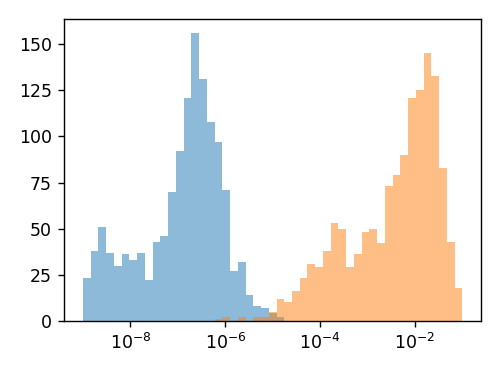

In [24]:
nd_C = NumericDiff(gradn, lambda gradh: gradh.C).derivative.reshape((natm, 3, nao, nao))
nd_U_1_vo = np.einsum("mu, Atup -> Atmp", np.linalg.inv(C), nd_C)[:, :, sv, so]
fig, ax = plt.subplots(figsize=(4, 3)); ax.set_xscale("log")
ax.hist(abs(U_1_vo.ravel() - nd_U_1_vo.ravel()), bins=np.logspace(np.log10(1e-9), np.log10(1e-1), 50), alpha=0.5)
ax.hist(abs(nd_U_1_vo.ravel()), bins=np.logspace(np.log10(1e-9), np.log10(1e-1), 50), alpha=0.5)
fig.tight_layout()

尽管在求解 B2PLYP 型泛函时，我们不一定要使用 U 矩阵；但上面的过程可以确认 CP-HF 方程可以在 GGA 下用程序实现，进而使用 Z-Vector 方法，求解双杂化泛函下的弛豫密度的非占-占据分块 $D_{ai}^\mathrm{PT2}$。

## B2PLYP 型泛函核坐标梯度

这里我们就几乎是再回顾一遍 MP2 核坐标梯度流程了。尽管 B2PLYP 型泛函在一些变量上定义与 MP2 较之略有区别，但大体上是相通的。

### PT2 相关能

B2PLYP 型泛函的能量分为自洽场部分 (SCF) 与二阶微扰部分 (PT2)，其中 PT2 部分定义如下：

$$
\begin{align}
E_\mathrm{PT2} &= T_{ij}^{ab} t_{ij}^{ab} D_{ij}^{ab} \\
T_{ij}^{ab} &= c_\mathrm{c} (2 t_{ij}^{ab} - t_{ij}^{ba}) \\
t_{ij}^{ab} &= (ia|jb) / D_{ij}^{ab} \\
D_{ij}^{ab} &= \varepsilon_i - \varepsilon_a + \varepsilon_j - \varepsilon_b
\end{align}
$$

除了在 $T_{ij}^{ab}$ 处引入了相关系数 $c_\mathrm{c}$ 之外，就与 MP2 近乎没有区别了。在 B2PLYP 中，该系数大小为 0.27。

In [25]:
T_iajb, t_iajb, D_iajb = gradh.T_iajb, gradh.t_iajb, gradh.D_iajb

In [26]:
np.allclose(cc * 2 * t_iajb - cc * t_iajb.swapaxes(-1, -3), T_iajb)

True

我们不妨再验证一下 B2PLYP 总能量的计算。

$$
E_\mathrm{tot} = E_\mathrm{nuc} + E_\mathrm{SCF} + E_\mathrm{PT2}
$$

In [27]:
gradh.scf_eng.energy_nuc() + gradh.scf_eng.energy_elec()[0] + (T_iajb * t_iajb * D_iajb).sum()

-151.20399655987893

pyxdh 所直接给出的 B2PLYP 总能量则为：

In [28]:
gradh.eng

-151.20399655987893

### PT2 能量梯度

如 MP2 一样，PT2 能量梯度也一样能写为

$$
\partial_{A_t} E_\mathrm{PT2} = D_{pq}^\mathrm{PT2} B_{pq}^{A_t} + W_{pq}^\mathrm{PT2} [\mathrm{I}] S_{pq}^{A_t} + 2 T_{ij}^{ab} (ia|jb)^{A_t}
$$

其中，弛豫密度 $D_{pq}^\text{PT2}$ 定义仍然是

$$
\begin{aligned}
D_{ij}^\text{PT2} &= - 2 T_{ik}^{ab} t_{jk}^{ab} \\
D_{ab}^\text{PT2} &= 2 T_{ij}^{ac} t_{ij}^{bc} \\
- (\varepsilon_a - \varepsilon_i) D_{ai}^\mathrm{PT2} - A_{ai, bj} D_{bj}^\mathrm{PT2} &= L_{ai} \\
D_{ia}^\mathrm{PT2} &= 0
\end{aligned}
$$

其中，

$$
\begin{align}
L_{ai} &= A_{ai, kl} D_{kl}^\mathrm{PT2} + A_{ai, bc} D_{bc}^\mathrm{PT2} - 4 T_{jk}^{ab} (ij|bk) + 4 T_{ij}^{bc} (ab|jc)
\end{align}
$$

In [29]:
D_r = np.zeros((nmo, nmo))
D_r[so, so] = - 2 * np.einsum("iakb, jakb -> ij", T_iajb, t_iajb)
D_r[sv, sv] = 2 * np.einsum("iajc, ibjc -> ab", T_iajb, t_iajb)
L = (
    + gradh.Ax0_Core(sv, so, sa, sa)(D_r)
    - 4 * np.einsum("jakb, ijbk -> ai", T_iajb, eri0_mo[so, so, sv, so])
    + 4 * np.einsum("ibjc, abjc -> ai", T_iajb, eri0_mo[sv, sv, so, sv])
)
D_r[sv, so] = cphf.solve(gradh.Ax0_Core(sv, so, sv, so), e, gradh.mo_occ, L, max_cycle=100)[0]

In [30]:
np.allclose(D_r, gradh.D_r)

True

以及 $W_{pq}^\mathrm{PT2} [\mathrm{I}]$ 定义仍然是

$$
\begin{align}
W_{ij}^\mathrm{PT2} [\mathrm{I}] &= - 2 T_{ik}^{ab} (ja|kb) \\
W_{ab}^\mathrm{PT2} [\mathrm{I}] &= - 2 T_{ij}^{ac} (ib|jc) \\
W_{ai}^\mathrm{PT2} [\mathrm{I}] &= - 4 T_{jk}^{ab} (ij|bk) \\
W_{ia}^\mathrm{PT2} [\mathrm{I}] &= 0
\end{align}
$$

In [31]:
W_I = np.zeros((nmo, nmo))
W_I = np.zeros((nmo, nmo))
W_I[so, so] = - 2 * np.einsum("iakb, jakb -> ij", T_iajb, eri0_mo[so, sv, so, sv])
W_I[sv, sv] = - 2 * np.einsum("iajc, ibjc -> ab", T_iajb, eri0_mo[so, sv, so, sv])
W_I[sv, so] = - 4 * np.einsum("jakb, ijbk -> ai", T_iajb, eri0_mo[so, so, sv, so])

In [32]:
np.allclose(W_I, gradh.W_I)

True

因此，总 PT2 能量的导数可以生成如下：

In [33]:
E_1_MP2_contrib = (
    + np.einsum("pq, Atpq -> At", D_r, B_1)
    + np.einsum("pq, Atpq -> At", W_I, S_1_mo)
    + 2 * np.einsum("iajb, Atiajb -> At", T_iajb, eri1_mo[:, :, so, sv, so, sv])
)
E_1_MP2_contrib

array([[ 0.01457, -0.00054,  0.02555],
       [-0.00174,  0.00928, -0.03034],
       [-0.01221, -0.00043, -0.00322],
       [-0.00061, -0.00832,  0.00801]])

而自洽场总能量导数可以使用父类 `GradSCF` 的函数生成：

In [34]:
E_1_SCF_contrib = GradSCF._get_E_1(gradh)
E_1_SCF_contrib

array([[-0.04938,  0.06774,  0.1109 ],
       [ 0.01107,  0.15143, -0.1389 ],
       [ 0.01952,  0.01315,  0.03539],
       [ 0.01879, -0.23232, -0.00739]])

总的能量梯度则表示如下：

In [35]:
E_1_SCF_contrib + E_1_MP2_contrib

array([[-0.03482,  0.0672 ,  0.13645],
       [ 0.00933,  0.16072, -0.16924],
       [ 0.00731,  0.01272,  0.03217],
       [ 0.01818, -0.24064,  0.00062]])

在 pyxdh 中，`E_1` 可以用来生成总能量梯度：

In [36]:
gradh.E_1

array([[-0.03482,  0.0672 ,  0.13645],
       [ 0.00933,  0.16072, -0.16924],
       [ 0.00731,  0.01272,  0.03217],
       [ 0.01818, -0.24064,  0.00062]])

我们也可以使用数值导数的方法生成总能量梯度：

In [37]:
nd_E_0 = NumericDiff(gradn, lambda gradh: gradh.eng).derivative
nd_E_0.reshape(natm, 3)

array([[-0.03481,  0.0672 ,  0.13644],
       [ 0.00933,  0.16072, -0.16923],
       [ 0.00731,  0.01272,  0.03217],
       [ 0.01818, -0.24064,  0.00062]])

In [38]:
np.allclose(E_1_SCF_contrib + E_1_MP2_contrib, nd_E_0.reshape(natm, 3))

False

## 演示任务：A 张量 GGA 贡献部分的缩并效率

在这里，我们统一处理的是 $A_{ai, bj}^\mathrm{GGA} X_{bj}^\mathbb{A}$ 问题 (作为结果的张量是 $(\mathbb{A}, a, i)$ 维度的)，其中 $\mathbb{A}$ 代表的维度数量是 5。

In [39]:
X = np.random.randn(5, nvir, nocc)

### 原子轨道下 A 张量的缩并

我们先回顾一下原子轨道下的缩并情况：

$$
\begin{align}
A_{\mu \nu, \kappa \lambda} \xleftarrow{\text{GGA contrib}} A_{\mu \nu, \kappa \lambda}^\text{GGA}
&= f_{\rho \rho} \phi_\kappa \phi_\lambda \phi_\mu \phi_\nu + 4 f_{\rho \gamma} \rho_r \phi_{r \kappa} \phi_\lambda \phi_\mu \phi_\nu \\
& + 4 f_{\rho \gamma} \phi_\kappa \phi_\lambda \rho_r \phi_{r \mu} \phi_{\nu} + 16 f_{\gamma \gamma} \rho_w \phi_{w \kappa} \phi_\lambda \rho_r \phi_{r \mu} \phi_{\nu} \\
& + 8 f_\gamma \phi_{r \kappa} \phi_\lambda \phi_{r \mu} \phi_{\nu} \\
& + \mathrm{swap} (\mu, \nu) + \mathrm{swap} (\kappa, \lambda)
\end{align}
$$

如果我们要求 $A_{ai, bj}^\mathrm{GGA} X_{bj}^\mathbb{A}$，那么我们还要经过一次张量缩并：

$$
A_{ai, bj}^\mathrm{GGA} X_{bj}^\mathbb{A} = C_{\mu a} C_{\nu i} A_{\mu \nu, \kappa \lambda}^\text{GGA} C_{\kappa b} X_{bj}^\mathbb{A} C_{\lambda j}
$$

这样一个过程相当花时间，因此我们只进行一次运行输出时间信息：

In [40]:
%%time
A_0_ao_GGA = (
    +      np.einsum("g, gk, gl, gu, gv -> uvkl"          , frr, ao_0, ao_0, ao_0, ao_0)
    + 4  * np.einsum("g, rg, rgk, gl, gu, gv -> uvkl"     , frg, rho_1, ao_1, ao_0, ao_0, ao_0)
    + 4  * np.einsum("g, gk, gl, rg, rgu, gv -> uvkl"     , frg, ao_0, ao_0, rho_1, ao_1, ao_0)
    + 16 * np.einsum("g, wg, wgk, gl, rg, rgu, gv -> uvkl", fgg, rho_1, ao_1, ao_0, rho_1, ao_1, ao_0)
    + 8  * np.einsum("g, rgk, gl, rgu, gv -> uvkl"        , fg, ao_1, ao_0, ao_1, ao_0)
)
A_0_ao_GGA += A_0_ao_GGA.swapaxes(-1, -2)
A_0_ao_GGA += A_0_ao_GGA.swapaxes(-3, -4)
Ax_GGA = np.einsum("ua, vi, uvkl, kb, Abj, lj -> Aai", Cv, Co, A_0_ao_GGA, Cv, X, Co)

CPU times: user 7.53 s, sys: 3.78 s, total: 11.3 s
Wall time: 12.6 s


我们来看一下为何需要消耗这么长时间。我们不妨先定义一个函数 `get_FLOP`，它能导出 np.einsum 在足够内存下会选用的张量缩并路径下，所预期的数值运算次数：

In [41]:
def get_FLOP(*args):
    return float(np.einsum_path(*args)[1].split("\n")[4].split(":")[1])

譬如说，对于 $f_{\rho \rho} \phi_\kappa \phi_\lambda \phi_\mu \phi_\nu$ 的缩并，np.einsum 预期会执行大约 4.254e+10 次的运算：

In [42]:
get_FLOP("g, gk, gl, gu, gv -> uvkl", frr, ao_0, ao_0, ao_0, ao_0)

42540000000.0

因此，上述张量缩并总共需要大约 2.130e+11 次的数值运算。

In [43]:
(
    + get_FLOP("g, gk, gl, gu, gv -> uvkl", frr, ao_0, ao_0, ao_0, ao_0)
    + get_FLOP("g, rg, rgk, gl, gu, gv -> uvkl", frg, rho_1, ao_1, ao_0, ao_0, ao_0)
    + get_FLOP("g, gk, gl, rg, rgu, gv -> uvkl", frg, ao_0, ao_0, rho_1, ao_1, ao_0)
    + get_FLOP("g, wg, wgk, gl, rg, rgu, gv -> uvkl", fgg, rho_1, ao_1, ao_0, rho_1, ao_1, ao_0)
    + get_FLOP("g, rgk, gl, rgu, gv -> uvkl", fg, ao_1, ao_0, ao_1, ao_0)
    + get_FLOP("ua, vi, uvkl, kb, Abj, lj -> Aai", Cv, Co, A_0_ao_GGA, Cv, X, Co)
)

212967700000.0

### 完整的缩并

刚才我们是先求出了 $A_{\mu \nu, \kappa \lambda}^\mathrm{GGA}$ 以进行缩并计算；但注意到我们的目标是 $A_{ai, bj}^\mathrm{GGA} X_{bj}^\mathbb{A}$，因此不妨将剩余的项都一起缩并，即

$$
\begin{align}
A_{ai, bj}^\mathrm{GGA} X_{bj}^\mathbb{A}
&=\quad C_{\mu a} C_{\nu i} C_{\kappa b} X_{bj}^\mathbb{A} C_{\lambda j}
\cdot f_{\rho \rho} \phi_\kappa \phi_\lambda \phi_\mu \phi_\nu \\
&\quad + C_{\mu a} C_{\nu i} C_{\kappa b} X_{bj}^\mathbb{A} C_{\lambda j}
\cdot 4 f_{\rho \gamma} \rho_r \phi_{r \kappa} \phi_\lambda \phi_\mu \phi_\nu \\
&\quad + C_{\mu a} C_{\nu i} C_{\kappa b} X_{bj}^\mathbb{A} C_{\lambda j}
\cdot 4 f_{\rho \gamma} \phi_\kappa \phi_\lambda \rho_r \phi_{r \mu} \phi_{\nu} \\
&\quad + C_{\mu a} C_{\nu i} C_{\kappa b} X_{bj}^\mathbb{A} C_{\lambda j}
\cdot 16 f_{\gamma \gamma} \rho_w \phi_{w \kappa} \phi_\lambda \rho_r \phi_{r \mu} \phi_{\nu} \\
&\quad + C_{\mu a} C_{\nu i} C_{\kappa b} X_{bj}^\mathbb{A} C_{\lambda j}
\cdot 8 f_\gamma \phi_{r \kappa} \phi_\lambda \phi_{r \mu} \phi_{\nu} \\
&\quad + \ldots
\end{align}
$$

其中，省略号表示的是各种依靠角标对称性进行的计算。程序表达如下：

In [44]:
%%time
Ax_GGA_complicated = (
    +      np.einsum("ua, vi, kb, Abj, lj, g,      gk, gl,      gu, gv -> Aai", Cv, Co, Cv, X, Co, frr, ao_0, ao_0, ao_0, ao_0)
    + 4  * np.einsum("ua, vi, kb, Abj, lj, g, rg, rgk, gl,      gu, gv -> Aai", Cv, Co, Cv, X, Co, frg, rho_1, ao_1, ao_0, ao_0, ao_0)
    + 4  * np.einsum("ua, vi, kb, Abj, lj, g,      gk, gl, rg, rgu, gv -> Aai", Cv, Co, Cv, X, Co, frg, ao_0, ao_0, rho_1, ao_1, ao_0)
    + 16 * np.einsum("ua, vi, kb, Abj, lj, g, wg, wgk, gl, rg, rgu, gv -> Aai", Cv, Co, Cv, X, Co, fgg, rho_1, ao_1, ao_0, rho_1, ao_1, ao_0)
    + 8  * np.einsum("ua, vi, kb, Abj, lj, g,     rgk, gl,     rgu, gv -> Aai", Cv, Co, Cv, X, Co, fg, ao_1, ao_0, ao_1, ao_0)
    +      np.einsum("va, ui, kb, Abj, lj, g,      gk, gl,      gu, gv -> Aai", Cv, Co, Cv, X, Co, frr, ao_0, ao_0, ao_0, ao_0)
    + 4  * np.einsum("va, ui, kb, Abj, lj, g, rg, rgk, gl,      gu, gv -> Aai", Cv, Co, Cv, X, Co, frg, rho_1, ao_1, ao_0, ao_0, ao_0)
    + 4  * np.einsum("va, ui, kb, Abj, lj, g,      gk, gl, rg, rgu, gv -> Aai", Cv, Co, Cv, X, Co, frg, ao_0, ao_0, rho_1, ao_1, ao_0)
    + 16 * np.einsum("va, ui, kb, Abj, lj, g, wg, wgk, gl, rg, rgu, gv -> Aai", Cv, Co, Cv, X, Co, fgg, rho_1, ao_1, ao_0, rho_1, ao_1, ao_0)
    + 8  * np.einsum("va, ui, kb, Abj, lj, g,     rgk, gl,     rgu, gv -> Aai", Cv, Co, Cv, X, Co, fg, ao_1, ao_0, ao_1, ao_0)
    +      np.einsum("ua, vi, lb, Abj, kj, g,      gk, gl,      gu, gv -> Aai", Cv, Co, Cv, X, Co, frr, ao_0, ao_0, ao_0, ao_0)
    + 4  * np.einsum("ua, vi, lb, Abj, kj, g, rg, rgk, gl,      gu, gv -> Aai", Cv, Co, Cv, X, Co, frg, rho_1, ao_1, ao_0, ao_0, ao_0)
    + 4  * np.einsum("ua, vi, lb, Abj, kj, g,      gk, gl, rg, rgu, gv -> Aai", Cv, Co, Cv, X, Co, frg, ao_0, ao_0, rho_1, ao_1, ao_0)
    + 16 * np.einsum("ua, vi, lb, Abj, kj, g, wg, wgk, gl, rg, rgu, gv -> Aai", Cv, Co, Cv, X, Co, fgg, rho_1, ao_1, ao_0, rho_1, ao_1, ao_0)
    + 8  * np.einsum("ua, vi, lb, Abj, kj, g,     rgk, gl,     rgu, gv -> Aai", Cv, Co, Cv, X, Co, fg, ao_1, ao_0, ao_1, ao_0)
    +      np.einsum("va, ui, lb, Abj, kj, g,      gk, gl,      gu, gv -> Aai", Cv, Co, Cv, X, Co, frr, ao_0, ao_0, ao_0, ao_0)
    + 4  * np.einsum("va, ui, lb, Abj, kj, g, rg, rgk, gl,      gu, gv -> Aai", Cv, Co, Cv, X, Co, frg, rho_1, ao_1, ao_0, ao_0, ao_0)
    + 4  * np.einsum("va, ui, lb, Abj, kj, g,      gk, gl, rg, rgu, gv -> Aai", Cv, Co, Cv, X, Co, frg, ao_0, ao_0, rho_1, ao_1, ao_0)
    + 16 * np.einsum("va, ui, lb, Abj, kj, g, wg, wgk, gl, rg, rgu, gv -> Aai", Cv, Co, Cv, X, Co, fgg, rho_1, ao_1, ao_0, rho_1, ao_1, ao_0)
    + 8  * np.einsum("va, ui, lb, Abj, kj, g,     rgk, gl,     rgu, gv -> Aai", Cv, Co, Cv, X, Co, fg, ao_1, ao_0, ao_1, ao_0)
)
print(np.allclose(Ax_GGA_complicated, Ax_GGA))

True
CPU times: user 1.81 s, sys: 484 ms, total: 2.3 s
Wall time: 2.5 s


很显然上面的式子太过冗长，一眼就像对其作公因式提取的处理，并且也比 `Ax_GGA` 消耗更多的代码；但它意外地节省时间。我们拿出其中的五行出来观察浮点计算次数：

In [45]:
(
    + get_FLOP("ua, vi, kb, Abj, lj, g, gk, gl, gu, gv -> Aai"          , Cv, Co, Cv, X, Co, frr, ao_0, ao_0, ao_0, ao_0)
    + get_FLOP("ua, vi, kb, Abj, lj, g, rg, rgk, gl, gu, gv -> Aai"     , Cv, Co, Cv, X, Co, frg, rho_1, ao_1, ao_0, ao_0, ao_0)
    + get_FLOP("ua, vi, kb, Abj, lj, g, gk, gl, rg, rgu, gv -> Aai"     , Cv, Co, Cv, X, Co, frg, ao_0, ao_0, rho_1, ao_1, ao_0)
    + get_FLOP("ua, vi, kb, Abj, lj, g, wg, wgk, gl, rg, rgu, gv -> Aai", Cv, Co, Cv, X, Co, fgg, rho_1, ao_1, ao_0, rho_1, ao_1, ao_0)
    + get_FLOP("ua, vi, kb, Abj, lj, g, rgk, gl, rgu, gv -> Aai"        , Cv, Co, Cv, X, Co, fg, ao_1, ao_0, ao_1, ao_0)
)

2315900000.0

上述浮点数乘以 4 即是 `Ax_GGA_complicated` 所需要消耗的计算量了，为 9.2636e+09 次。而 `Ax_GGA` 尽管有更短的代码和简洁的公式，却需要消耗 2.130e+11 次。

作为一个例子，我们看一下第二项 $C_{\mu a} C_{\nu i} C_{\kappa b} X_{bj}^\mathbb{A} C_{\lambda j} \cdot 4 f_{\rho \gamma} \rho_r \phi_{r \kappa} \phi_\lambda \phi_\mu \phi_\nu$ 是如何进行张量缩并的：

In [46]:
print(np.einsum_path("ua, vi, kb, Abj, lj, g, rg, rgk, gl, gu, gv -> Aai", Cv, Co, Cv, X, Co, frg, rho_1, ao_1, ao_0, ao_0, ao_0)[1])

  Complete contraction:  ua,vi,kb,Abj,lj,g,rg,rgk,gl,gu,gv->Aai
         Naive scaling:  11
     Optimized scaling:  4
      Naive FLOP count:  4.794e+16
  Optimized FLOP count:  4.124e+08
   Theoretical speedup:  116236931.476
  Largest intermediate:  4.077e+06 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   3                  rgk,rg->kg       ua,vi,kb,Abj,lj,g,gl,gu,gv,kg->Aai
   3                   gv,vi->ig          ua,kb,Abj,lj,g,gl,gu,kg,ig->Aai
   3                   gl,lj->jg             ua,kb,Abj,g,gu,kg,ig,jg->Aai
   3                   gu,ua->ag                kb,Abj,g,kg,ig,jg,ag->Aai
   3                   kg,kb->bg                   Abj,g,ig,jg,ag,bg->Aai
   2                    ig,g->ig                     Abj,jg,ag,bg,ig->Aai
   4                 bg,Abj->Ajg                        jg,a

其大致思路是，首先将原子轨道格点缩并到分子轨道格点：

$$
\phi_p = \phi_\mu C_{\mu p}
$$

但这其中存在例外：

$$
\begin{align}
(\nabla_\rho \cdot \nabla \phi)_\mu &= \rho_r \phi_{r \mu} \\
(\nabla_\rho \cdot \nabla \phi)_k &= (\nabla_\rho \cdot \nabla \phi)_\mu C_{\mu k}
\end{align}
$$

如此缩并的原因单纯地是因为效率高。随后优先缩并含 $b, j$ 两个角标：

$$
X_{bj}^\mathbb{A} (\nabla_\rho \cdot \nabla \phi)_k \phi_j \rightarrow \varphi^\mathbb{A}
$$

最后对剩下的项依次缩并即可。

### pyxdh 所使用的缩并方式

需要说明的是，pyxdh 在求取 $A_{ai, bj} X_{bj}^\mathbb{A}$ 问题时，所使用的仍然是 PySCF 的程序。这一段是为了以后 pyxdh 中 `Ax1_Core` 张量缩并函数 $A_{ai, bj}^\mathbb{B} X_{bj}^\mathbb{A}$ 作准备的。

我们不采取上面相对来说激进的缩并方式，即仍然保留原子轨道格点；但我们借助这些原子轨道格点，生成与自洽场密度有别的类密度量。我们先定义原子轨道下的类密度 `dmX`:

$$
X_{\kappa \lambda}^\mathbb{A} = C_{\kappa b} X_{bj}^\mathbb{A} C_{\lambda j} + \mathrm{swap} (\kappa, \lambda)
$$

In [47]:
dmX = np.einsum("kb, Abj, lj -> Akl", Cv, X, Co)
dmX += dmX.swapaxes(-1, -2)

以上述类密度为前提，我们可以生成类密度的密度格点 `rho_X_0`

$$
\varrho^\mathbb{A} = X_{\kappa \lambda}^\mathbb{A} \phi_\kappa \phi_\lambda
$$

及其梯度 `rho_X_1`

$$
\varrho_r^\mathbb{A} = 2 X_{\kappa \lambda}^\mathbb{A} \phi_{r \kappa} \phi_\lambda
$$

In [48]:
tmp_K = np.einsum("Akl, gl -> Agk", dmX, ao_0)
rho_X_0 = np.einsum("gk, Agk -> Ag", ao_0, tmp_K)
rho_X_1 = 2 * np.einsum("rgk, Agk -> Arg", ao_1, tmp_K)

我们额外定义密度梯度的一种导出量 `gamma_XD`

$$
\varrho_r^\mathbb{A} \rho_r \, (\text{summed by } r)
$$

In [49]:
gamma_XD = np.einsum("Arg, rg -> Ag", rho_X_1, rho_1)

随后我们就将 $A_{ai, bj}^\mathrm{GGA} X_{bj}^\mathbb{A}$ 所有缩并项作化简；化简的原则是将所有 $b, j, \kappa, \lambda$ 的角标先求和。在这种化简的思路下，我们定义两个临时的变量 `M_0`：

$$
M^\mathbb{A} = f_{\rho \rho} \varrho^\mathbb{A} + 2 f_{\rho \gamma} (\varrho_w^\mathbb{A} \rho_w)
$$

以及 `M_1`

$$
M_r^\mathbb{A} = 4 f_{\rho \gamma} \varrho^\mathbb{A} \rho_r + 8 f_{\rho \gamma} (\varrho_w^\mathbb{A} \rho_w) \rho_r + 4 f_\gamma \varrho_r^\mathbb{A}
$$

我们回顾到

$$
\begin{align}
A_{\mu \nu, \kappa \lambda} \xleftarrow{\text{GGA contrib}} A_{\mu \nu, \kappa \lambda}^\text{GGA}
&= f_{\rho \rho} \phi_\kappa \phi_\lambda \phi_\mu \phi_\nu + 4 f_{\rho \gamma} \rho_r \phi_{r \kappa} \phi_\lambda \phi_\mu \phi_\nu \\
& + 4 f_{\rho \gamma} \phi_\kappa \phi_\lambda \rho_r \phi_{r \mu} \phi_{\nu} + 16 f_{\gamma \gamma} \rho_w \phi_{w \kappa} \phi_\lambda \rho_r \phi_{r \mu} \phi_{\nu} \\
& + 8 f_\gamma \phi_{r \kappa} \phi_\lambda \phi_{r \mu} \phi_{\nu} \\
& + \mathrm{swap} (\mu, \nu) + \mathrm{swap} (\kappa, \lambda)
\end{align}
$$

其中，$M^\mathbb{A}$ 所包含的项与上式的第一行有关，$M_r^\mathbb{A}$ 则与第二、三行有关。

In [50]:
M_0 = (
    np.einsum("g, Ag -> Ag", frr, rho_X_0)
    + 2 * np.einsum("g, Ag -> Ag", frg, gamma_XD)
)
M_1 = (
    + 4 * np.einsum("g, Ag, rg -> Arg", frg, rho_X_0, rho_1)
    + 8 * np.einsum("g, Ag, rg -> Arg", fgg, gamma_XD, rho_1)
    + 4 * np.einsum("g, Arg -> Arg", fg, rho_X_1)
)

最后，

$$
\begin{align}
A_{\mu \nu, \kappa \lambda} X_{\kappa \lambda}^\mathbb{A} &= M^\mathbb{A} \phi_\mu \phi_\nu + M_r^\mathbb{A} \phi_{r \mu} \phi_\nu + \mathrm{swap} (\mu, \nu) \\
A_{ai, bj}^\mathrm{GGA} X_{bj}^\mathbb{A} &= A_{\mu \nu, \kappa \lambda} X_{\kappa \lambda}^\mathbb{A} C_{\mu a} C_{\nu i}
\end{align}
$$

In [51]:
Ax_ao_GGA = (
    + np.einsum("Ag, gu, gv -> Auv", M_0, ao_0, ao_0)
    + np.einsum("Arg, rgu, gv -> Auv", M_1, ao_1, ao_0)
)
Ax_ao_GGA += Ax_ao_GGA.swapaxes(-1, -2)
Ax_GGA_modified = np.einsum("ua, Auv, vi -> Aai", Cv, Ax_ao_GGA, Co)

我们可以验证上述的计算过程是正确的：

In [52]:
np.allclose(Ax_GGA, Ax_GGA_modified)

True

其消耗时长可以用下面的程序给出：

In [53]:
%%time
dmX = np.einsum("kb, Abj, lj -> Akl", Cv, X, Co)
dmX += dmX.swapaxes(-1, -2)
tmp_K = np.einsum("Akl, gl -> Agk", dmX, ao_0)
rho_X_0 = np.einsum("gk, Agk -> Ag", ao_0, tmp_K)
rho_X_1 = 2 * np.einsum("rgk, Agk -> Arg", ao_1, tmp_K)
gamma_XD = np.einsum("Arg, rg -> Ag", rho_X_1, rho_1)
M_0 = (
    np.einsum("g, Ag -> Ag", frr, rho_X_0)
    + 2 * np.einsum("g, Ag -> Ag", frg, gamma_XD)
)
M_1 = (
    + 4 * np.einsum("g, Ag, rg -> Arg", frg, rho_X_0, rho_1)
    + 8 * np.einsum("g, Ag, rg -> Arg", fgg, gamma_XD, rho_1)
    + 4 * np.einsum("g, Arg -> Arg", fg, rho_X_1)
)
Ax_ao_GGA = (
    + np.einsum("Ag, gu, gv -> Auv", M_0, ao_0, ao_0)
    + np.einsum("Arg, rgu, gv -> Auv", M_1, ao_1, ao_0)
)
Ax_ao_GGA += Ax_ao_GGA.swapaxes(-1, -2)
Ax_GGA_modified = np.einsum("ua, Auv, vi -> Aai", Cv, Ax_ao_GGA, Co)

CPU times: user 281 ms, sys: 312 ms, total: 594 ms
Wall time: 609 ms


这种方式在张量运算过程中，所消耗的浮点运算数量大约是 1.4756e+09 次：

In [54]:
(
    + get_FLOP("kb, Abj, lj -> Akl", Cv, X, Co)
    + get_FLOP("Akl, gl -> Agk", dmX, ao_0)
    + get_FLOP("gk, Agk -> Ag", ao_0, tmp_K)
    + get_FLOP("rgk, Agk -> Arg", ao_1, tmp_K)
    + get_FLOP("Arg, rg -> Ag", rho_X_1, rho_1)
    + get_FLOP("g, Ag -> Ag", frr, rho_X_0)
    + get_FLOP("g, Ag -> Ag", frg, gamma_XD)
    + get_FLOP("g, Ag, rg -> Arg", frg, rho_X_0, rho_1)
    + get_FLOP("g, Ag, rg -> Arg", fgg, gamma_XD, rho_1)
    + get_FLOP("g, Arg -> Arg", fg, rho_X_1)
    + get_FLOP("Ag, gu, gv -> Auv", M_0, ao_0, ao_0)
    + get_FLOP("Arg, rgu, gv -> Auv", M_1, ao_1, ao_0)
    + get_FLOP("ua, Auv, vi -> Aai", Cv, Ax_ao_GGA, Co)
)

1475587600.0

其计算速度之所以可以更快，是因为对不少可以提取出来的中间变量作临时储存，并且利用到了角标对称性。

PySCF 的内置程序事实上可以在 $\mathbb{A}$ 所代表的维度较大时有更好的表现，这可能是因为 PySCF 使用到了 C 语言的底层。